# Installations

In [1]:
from IPython.display import clear_output

In [2]:
!git clone https://github.com/DinarZayahov/thesaurus.git

clear_output()

In [3]:
!pip install -r thesaurus/requirements.txt

clear_output()

In [4]:

import pickle
import requests
import os
import tarfile
import torch
import spacy
import nltk
import numpy as np

from minisom import MiniSom
from gensim.utils import tokenize
from transformers import BertTokenizer, BertModel, logging
from google.colab import drive
from google.colab import files

from bokeh.models import ColumnDataSource, HoverTool
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, output_file

from matplotlib import cm
from collections import Counter
from tqdm import tqdm

# display bokeh plot in notebook
output_notebook()

logging.set_verbosity_error()

In [5]:
%cd thesaurus/source

/content/thesaurus/source


In [6]:
path = '../data/'
with open(path+'2017', 'rb') as f_2017:
  data_2017 = pickle.load(f_2017)

with open(path+'2020', 'rb') as f_2020:
  data_2020 = pickle.load(f_2020)

with open(path+'2010', 'rb') as f_2010:
  data_2010 = pickle.load(f_2010)

with open(path+'shakespeare.txt', 'r') as f_shakespeare:
  shakespeare = f_shakespeare.read()

In [7]:
from downloads import download_model

In [8]:
download_model()

In [9]:
nltk.download('words')
nltk.download('wordnet')

clear_output()

In [10]:
from thesaurus import Thesaurus

In [11]:
model = BertModel.from_pretrained('bert-base-uncased',
           output_hidden_states = True)

model.eval()

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

clear_output()

# Preprocess foreground

In [12]:
# texts is the dictionary with all source texts that will be preprocessed
# texts = {'foreground name1': [source text1, source text2, ...], 'foreground name2': [source text1, source text2, ...], ...}
foreground_texts = dict()

# list of foreground names
# foreground_names = ['foreground name1', ...]
foreground_names = []

# dictionary with the embeddings and tokens of each foreground unit
# processed_foregrounds = {'foreground_name1': {'embeds': embeddings, 'words': tokens}, ...}
processed_foregrounds = dict()

In [13]:
# preprocess Physics articles
foreground_name1 = 'Physics articles 2017'

foreground_texts[foreground_name1] = []

foreground_names.append(foreground_name1)

num_of_articles = 10
for physics_article in data_2017[:num_of_articles]:
  try:
    foreground_texts[foreground_name1].append(physics_article['clean'])
  except KeyError:
    continue

In [15]:
# preprocess Shakespeare's poem
foreground_name2 = 'Lover\'s Complaint by William Shakespeare'

foreground_texts[foreground_name2] = [shakespeare]

foreground_names.append(foreground_name2)

In [16]:
MODEL = 'en_core_web_md-3.0.0/en_core_web_md/en_core_web_md-3.0.0'

obj = Thesaurus()
obj.set_spacy_model(MODEL)

/usr/local/lib/python3.7/dist-packages/spacy/util.py:837: UserWarning: [W095] Model 'en_core_web_md' (3.0.0) was trained with spaCy v3.0 and may not be 100% compatible with the current version (3.3.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [17]:
for foreground_unit in tqdm(foreground_names):

  all_embeddings_of_unit, all_words_of_unit = obj.process_texts(foreground_texts[foreground_unit])

  one_processed_foreground = {'embeds': all_embeddings_of_unit, 'words': all_words_of_unit}
  processed_foregrounds[foreground_unit] = one_processed_foreground

100%|██████████| 2/2 [00:41<00:00, 20.88s/it]


# Preprocess background

In [18]:
background_texts = []

In [19]:
if os.path.isfile(path+'coca_embeds.pickle') and os.path.isfile(path+'coca_tokens.pickle'):
  embeds = open(path+'coca_embeds.pickle', 'rb')
  background_embeds = pickle.load(embeds)

  tokens = open(path+'coca_tokens.pickle', 'rb')
  background_words = pickle.load(tokens)
else:

  background_embeds, background_words = obj.process_texts(background_texts)

# Demo

In [22]:
fig, som = obj.plot_bokeh(background_embeds, background_words, foreground_names, processed_foregrounds)
print("Go to https://nbviewer.org/github/DinarZayahov/thesaurus/blob/master/ThesaurusVisualization.ipynb to see the outputs of the notebook as the GitHub doesn't render dynamic output")
show(fig)

Go to https://nbviewer.org/github/DinarZayahov/thesaurus/blob/master/ThesaurusVisualization.ipynb to see the outputs of the notebook as the GitHub doesn't render dynamic output


In [ ]:
# three color depth levels, light, middle, dark color -> kinda differentiable on grayscale
# physics 2017 10 articles vs shakespeare
# 30 seconds

In [ ]:
fig, som = obj.plot_bokeh(background_embeds, background_words, foreground_names, processed_foregrounds)
print("Go to https://nbviewer.org/github/DinarZayahov/thesaurus/blob/master/ThesaurusVisualization.ipynb to see the outputs of the notebook as the GitHub doesn't render dynamic output",)
show(fig)

In [ ]:
# not differentiable on grayscale but colors not splashy (пёстрый)
# physics: 2010 vs 2020. 100 articles from each year
# 3 mins

In [ ]:
fig, som = obj.plot_bokeh(background_embeds, background_words, foreground_names, processed_foregrounds)
show(fig)

151


# Search

In [ ]:
def search(som, fig, words, embeds, search_word, search_color='blue'):
  
  try:
    index = words.index(search_word)


    label = []

    weight_x, weight_y = [], []
    
    w = som.winner(embeds[index])
    wx, wy = som.convert_map_to_euclidean(xy=w)
    wy = wy * np.sqrt(3) / 2
    weight_x.append(wx)
    weight_y.append(wy)
    label.append(search_word)

    source_pages = ColumnDataSource(
        data=dict(
            wx=weight_x,
            wy=weight_y,
            species=label
        )
    )

    point = fig.scatter(x='wy', y='wx', source=source_pages,
                  line_width=0.1, fill_color=search_color, size=4)
    circle = fig.scatter(x='wy', y='wx', source=source_pages,
                  line_color=search_color, line_width=1, line_alpha=1, 
                  fill_alpha=0, 
                  size=160)
    
    show(fig)

    return point, circle

  except ValueError:
    print('No such a word in map')

    return None, None

point, circle = None, None

In [ ]:
if point != None and circle != None:
  point.visible, circle.visible = False, False
point, circle = search(som, fig, background_words, background_embeds, 'overload')

# Time

In [ ]:
# preprocess text
# plot

In [ ]:
import matplotlib.pyplot as plt
import time

nums = [10, 100, 1000]

num_of_words = []
times = []

for num in nums:
  
  obj = Thesaurus()
  obj.set_spacy_model(MODEL)

  a = []
  for article in data_2017[:num]:
    try:
      a.append(article['clean'])
    except KeyError:
      continue

  b, c = obj.process_texts(a)
  num_of_words.append(len(b))

  start = time.time()
  # fig, som = obj.plot_bokeh(background_embeds, background_words, foreground_names=['no name'], preprocessed_foregrounds={'no name': {'embeds': b, 'words': c}}, background_color='#d2e4f5', foreground_colors=['#f5a09a', 'green'])
  gs = int(np.ceil(np.sqrt(len(b))))
  _ = obj.get_som(gs, b, mode='train')
  times.append(time.time()-start)

100%|██████████| 998/998 [30:45<00:00,  1.85s/it]


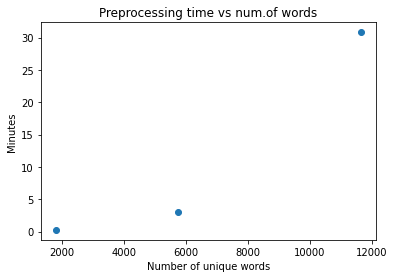

In [ ]:
plt.xlabel('Number of unique words')
plt.ylabel('Minutes')
plt.title('Preprocessing time vs num.of words')
plt.scatter(num_of_words, [t/60 for t in times])

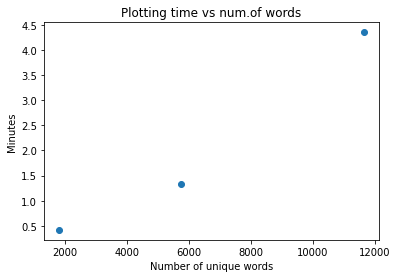

In [ ]:
plt.xlabel('Number of unique words')
plt.ylabel('Minutes')
plt.title('Plotting time vs num.of words')
plt.scatter(num_of_words, [t/60 for t in times])

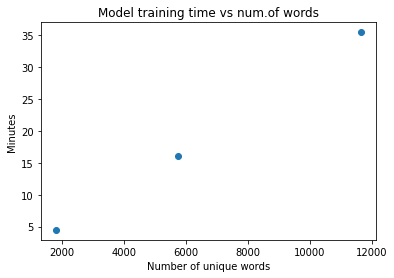

In [ ]:
plt.xlabel('Number of unique words')
plt.ylabel('Minutes')
plt.title('Model training time vs num.of words')
plt.scatter(num_of_words, [t/60 for t in times])